<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터 불러오기</a></span></li><li><span><a href="#함수-생성" data-toc-modified-id="함수-생성-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>함수 생성</a></span></li><li><span><a href="#마지막-값" data-toc-modified-id="마지막-값-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>마지막 값</a></span></li><li><span><a href="#그래프-그리기" data-toc-modified-id="그래프-그리기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>그래프 그리기</a></span></li></ul></div>

# keras를 사용하여 암호화화폐 예측하기 - 3. 예측하기

이전에 작성한 코드들을 사용하여 함수로 만들겠습니다.

## 데이터 불러오기

먼저 데이터를 불러오는 함수를 생성합니다. csv는 다운 받은 상태 이후에서 진행합니다.

In [1]:
import pandas as pd    
import numpy as np

def load_data(file_name = 'hour_Bithumb_XRP_KRW.csv', look_back = 10):
    data = pd.read_csv(file_name)

    high_low_data = data[['high','low']]
    data = high_low_data.dropna(axis=0, how='any')

    min_low = data.min(axis=0).low
    data -= min_low
    max_high = data.max(axis=0).high
    data /= max_high

    data_arr = data.values

    data_x, data_y = [], []
    for i in range(len(data_arr) - look_back):
        data_x.append(data_arr[i:(i+look_back)])
        data_y.append(data_arr[i+look_back])

    x_train = np.array(data_x)
    y_train = np.array(data_y)
    
    return x_train, y_train    

생성한 함수가 정상적으로 동작하는지 확인해 보겠습니다. 마지막 값을 확인해보기 위해 `-1`을 사용하였습니다.

In [2]:
x_train, y_train = load_data()
print("X", x_train[-1])
print("Y", y_train[-1])

X [[ 0.17827004  0.17299578]
 [ 0.19514768  0.17352321]
 [ 0.19620253  0.1835443 ]
 [ 0.19620253  0.18670886]
 [ 0.1935654   0.18618143]
 [ 0.19514768  0.18934599]
 [ 0.19567511  0.18829114]
 [ 0.1914557   0.18565401]
 [ 0.19409283  0.18670886]
 [ 0.19040084  0.17879747]]
Y [ 0.18776371  0.18407173]


## 함수 생성

훈련 하는 함수를 생성합니다. 예측에 사용하기 위해 마지막에 model을 반합니다. 

In [3]:
model_name = "xrp_hour.h5"

def train_model(train_count):
    model = load_saved_model()
    for i in range(train_count):
        print("train_step:{}".format(i+1))
        model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False)
        model.reset_states()
    model.save(model_name)
    return model

필요한 load_saved_model(), create_model() 함수를 생성합니다. 이전에 작성한 코드를 사용합니다.

In [4]:
from keras.models import load_model

def load_saved_model():
    try:
        model = load_model(model_name)
    except:
        model = create_model()
    return model

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def create_model():
    batch_size = 1
    look_back = 10
    feature = 2

    model = Sequential()
    for i in range(3):
        model.add(LSTM(32, batch_input_shape=(batch_size, look_back, feature), stateful=True, return_sequences=True))
        model.add(Dropout(0.1))
    model.add(LSTM(32, batch_input_shape=(batch_size, look_back, feature), stateful=True))
    model.add(Dropout(0.1))
    model.add(Dense(feature))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

모델을 불러오고, 훈련하고, 저장하는 trian_model 함수를 호출합니다. 모델을 반환받아서 예측에 사용합니다.

In [6]:
model = train_model(2)

train_step:1
Epoch 1/1
327/327 [==============================] - 29s 87ms/step - loss: 0.0343
train_step:2
Epoch 1/1
327/327 [==============================] - 25s 78ms/step - loss: 0.0383


마지막 값을 사용하여 이후에 변동될 값을 예측합니다.

In [7]:
xhat = x_train[-1]
prediction = model.predict(np.array([xhat]), batch_size=1)
print(xhat, prediction)

[[ 0.17827004  0.17299578]
 [ 0.19514768  0.17352321]
 [ 0.19620253  0.1835443 ]
 [ 0.19620253  0.18670886]
 [ 0.1935654   0.18618143]
 [ 0.19514768  0.18934599]
 [ 0.19567511  0.18829114]
 [ 0.1914557   0.18565401]
 [ 0.19409283  0.18670886]
 [ 0.19040084  0.17879747]] [[ 0.2119216   0.20924547]]


## 마지막 값

x_train[-1], y_train[-1]은 이미 알고 있는 값입니다.
알고 싶은 것은 앞으로 변동될 값이므로, 이를 변경합니다.

In [8]:
xhat = x_train[-1]
last = np.vstack([xhat[1:], y_train[-1]])
last

array([[ 0.19514768,  0.17352321],
       [ 0.19620253,  0.1835443 ],
       [ 0.19620253,  0.18670886],
       [ 0.1935654 ,  0.18618143],
       [ 0.19514768,  0.18934599],
       [ 0.19567511,  0.18829114],
       [ 0.1914557 ,  0.18565401],
       [ 0.19409283,  0.18670886],
       [ 0.19040084,  0.17879747],
       [ 0.18776371,  0.18407173]])

마지막 입력값을 구했으니, 이를 사용해서 `high, low` 값을 예측합니다. 

In [9]:
prediction = model.predict(np.array([last]))
prediction

array([[ 0.18885973,  0.17794771]], dtype=float32)

## 그래프 그리기

예측값을 사용해서 그래프를 생성합니다.

In [10]:
import matplotlib.pyplot as plt

def draw(model, last, look_forward = 50):
    high_list = np.zeros((look_forward))
    low_list = np.zeros((look_forward))

    for i in range(look_forward):
        prediction = model.predict(np.array([last]), batch_size=1)        
        prediction = prediction[0]
        high_list[i] = prediction[0]
        low_list[i] = prediction[1]
        last = np.vstack([last[1:],prediction])

    plt.plot(high_list, label="predict_high")
    plt.plot(low_list, label="predict_low")
    plt.legend()
    plt.show()
    
    return high_list, low_list

train_step:1
Epoch 1/1
327/327 [==============================] - 26s 80ms/step - loss: 0.0368
train_step:2
Epoch 1/1
327/327 [==============================] - 25s 75ms/step - loss: 0.0365
train_step:3
Epoch 1/1
327/327 [==============================] - 25s 77ms/step - loss: 0.0433
train_step:4
Epoch 1/1
327/327 [==============================] - 25s 77ms/step - loss: 0.0441
train_step:5
Epoch 1/1
327/327 [==============================] - 24s 75ms/step - loss: 0.0352


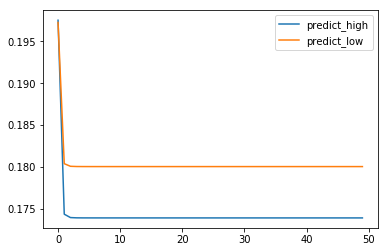

In [11]:
model = train_model(5)
high_list, low_list = draw(model, last)

원하는 그래프가 나오지 않는 다면 학습을 더 진행합니다. 훈련 숫자를 변경하거나, 아래 코드를 여러번 실행하여 훈련을 진행합니다. 훈련을 진행 할수록 결과 그래프가 바뀌는 것을 볼 수 있습니다.

> 200번 이상 훈련이 되도록 실행합니다. 

train_step:1
Epoch 1/1
327/327 [==============================] - 25s 78ms/step - loss: 0.0406
train_step:2
Epoch 1/1
327/327 [==============================] - 26s 80ms/step - loss: 0.0426
train_step:3
Epoch 1/1
327/327 [==============================] - 26s 80ms/step - loss: 0.0414
train_step:4
Epoch 1/1
327/327 [==============================] - 27s 81ms/step - loss: 0.0413
train_step:5
Epoch 1/1
327/327 [==============================] - 26s 78ms/step - loss: 0.0412
train_step:6
Epoch 1/1
327/327 [==============================] - 25s 77ms/step - loss: 0.0412
train_step:7
Epoch 1/1
327/327 [==============================] - 23s 70ms/step - loss: 0.0412
train_step:8
Epoch 1/1
327/327 [==============================] - 23s 70ms/step - loss: 0.0412
train_step:9
Epoch 1/1
327/327 [==============================] - 23s 70ms/step - loss: 0.0412
train_step:10
Epoch 1/1
327/327 [==============================] - 24s 72ms/step - loss: 0.0412
train_step:11
Epoch 1/1
327/327 [================

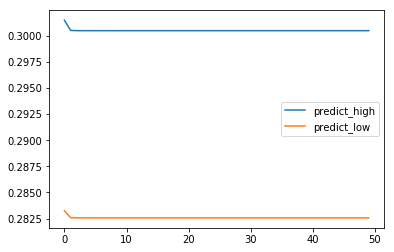

train_step:1
Epoch 1/1
327/327 [==============================] - 23s 71ms/step - loss: 0.0427
train_step:2
Epoch 1/1
327/327 [==============================] - 24s 73ms/step - loss: 0.0414
train_step:3
Epoch 1/1
327/327 [==============================] - 24s 73ms/step - loss: 0.0413
train_step:4
Epoch 1/1
327/327 [==============================] - 23s 69ms/step - loss: 0.0413
train_step:5
Epoch 1/1
327/327 [==============================] - 26s 79ms/step - loss: 0.0412
train_step:6
Epoch 1/1
327/327 [==============================] - 25s 78ms/step - loss: 0.0412
train_step:7
Epoch 1/1
327/327 [==============================] - 26s 79ms/step - loss: 0.0412
train_step:8
Epoch 1/1
327/327 [==============================] - 24s 72ms/step - loss: 0.0412
train_step:9
Epoch 1/1
327/327 [==============================] - 23s 71ms/step - loss: 0.0412
train_step:10
Epoch 1/1
327/327 [==============================] - 24s 73ms/step - loss: 0.0412
train_step:11
Epoch 1/1
327/327 [================

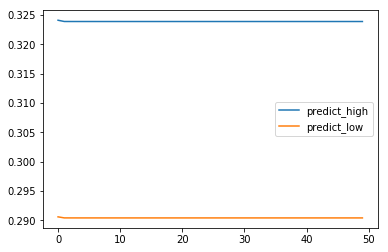

train_step:1
Epoch 1/1
327/327 [==============================] - 26s 80ms/step - loss: 0.0424
train_step:2
Epoch 1/1
327/327 [==============================] - 24s 74ms/step - loss: 0.0417
train_step:3
Epoch 1/1
327/327 [==============================] - 23s 72ms/step - loss: 0.0412
train_step:4
Epoch 1/1
327/327 [==============================] - 23s 70ms/step - loss: 0.0413
train_step:5
Epoch 1/1
327/327 [==============================] - 23s 71ms/step - loss: 0.0412
train_step:6
Epoch 1/1
327/327 [==============================] - 23s 69ms/step - loss: 0.0412
train_step:7
Epoch 1/1
327/327 [==============================] - 23s 72ms/step - loss: 0.0412
train_step:8
Epoch 1/1
327/327 [==============================] - 23s 70ms/step - loss: 0.0412
train_step:9
Epoch 1/1
327/327 [==============================] - 24s 73ms/step - loss: 0.0412
train_step:10
Epoch 1/1
327/327 [==============================] - 26s 78ms/step - loss: 0.0412
train_step:11
Epoch 1/1
327/327 [================

In [ ]:
for i in range(10):  
    model = train_model(20)
    high_list, low_list = draw(model, last)
    del model

위에서 나온 min_low, max_high 값을 사용하여 값을 복원할 수 있습니다. 

:-) 감사합니다.